In [1]:
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
import numpy as np
from os import scandir, walk, remove
import pandas as pd
from fastprogress import progress_bar
from fastai import *
from fastai.vision import *
from PIL import Image
from numbers import Integral

In [2]:
def center_crop(img, new_width=64, new_height=None):        
    width = img.width
    height = img.height

    if new_height is None:
        new_height = new_width

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))
   
    center_cropped_img = img.crop((left, top, right, bottom))
    assert((center_cropped_img.height == new_height) and (center_cropped_img.width == new_width))

    return center_cropped_img

def crop_on_img(filename, path_target, size=41):
    img = Image.open(filename)
    img = center_crop(img, size, size)
    img.save(path_target+filename.stem+'.png')

In [3]:
def do(file,i):
    crop_on_img(file, path_target, 512)
    
LAUNCH = True
# Path where your downloaded data is
path_source = '/home/jupyter/Nepal/WFP_Nepal_RGB-Scale3.5_PNG/'
# Target path of resized data
path_target = '/home/jupyter/Nepal/CenterCropped-3.5/'
files = ImageList.from_folder(path_source).items

# parallel(do,files)

# ResNet Baseline

In [4]:
# !gdrive download 1AU7pZVL5xDotl13jCaoT7a2xwZUZfiT2

In [5]:
trn_val = pd.read_csv("train_test_split.csv")

In [6]:
trn_val_dict = {row.fname: row.is_val_set for _, row in trn_val.iterrows()}

In [7]:
def get_split(fname):
      return trn_val_dict[fname.name]

In [8]:
import re
pat = '^rice_'

def is_rice(fname):
    if re.search(pat,fname.stem): return True
    return False

In [9]:
src = (ImageList.from_folder(Path(path_target))
        .split_by_valid_func(get_split)
        .label_from_func(is_rice)
      )
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src.transform(tfms,size=224)
        .databunch(bs=40)
        .normalize(imagenet_stats)
       )

In [10]:
def f1_score(y_pred:Tensor, y_true:Tensor,beta:float=1, eps:float=1e-9)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2

    y_pred = y_pred.argmax(dim=1).float()
    y_true = y_true.float()
    
    TP = (y_pred*y_true).sum()
    prec = TP/(y_pred.sum()+eps)
    rec = TP/(y_true.sum()+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, f1_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 1.32E-03


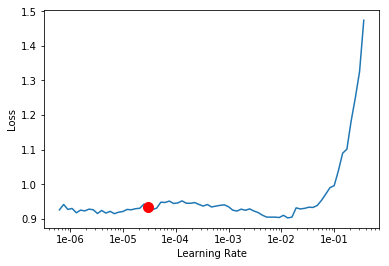

In [34]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [35]:
learn.fit_one_cycle(4,5e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.650044,0.635771,0.657623,0.588879,01:17
1,0.601561,0.646909,0.657241,0.619781,01:17
2,0.527090,0.551676,0.691250,0.613185,01:18
3,0.481996,0.536933,0.719526,0.674510,01:17


In [36]:
learn.save('resnet-1-224')

In [37]:
learn.unfreeze()
learn.fit_one_cycle(4,slice(5e-5,5e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.527162,0.590424,0.681697,0.552294,01:21
1,0.480869,0.583591,0.702713,0.674790,01:23
2,0.411522,0.511646,0.759266,0.726639,01:24
3,0.369239,0.540437,0.742835,0.693939,01:24


In [40]:
learn.save('resnet-2-224')

In [41]:
learn.load('resnet-1-224');
learn.unfreeze()
learn.fit_one_cycle(4,slice(1e-6,5e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.471181,0.562742,0.691632,0.603831,01:23
1,0.459769,0.541304,0.723729,0.669643,01:24
2,0.421142,0.532699,0.732136,0.687929,01:24
3,0.396389,0.535182,0.729079,0.680407,01:24


In [42]:
learn.fit_one_cycle(4,slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.406137,0.547558,0.721437,0.675568,01:23
1,0.396774,0.526921,0.747039,0.711364,01:24
2,0.381873,0.536335,0.741307,0.696444,01:25
3,0.360118,0.525918,0.747421,0.710383,01:25


# Resnet with Pairwise Confusion

In [18]:
learn.load('resnet-1-224');

In [24]:
class PWCLoss():
    def __init__(self,l=1):
        self.l = l
        self.train = True
    def __call__(self,inp,targ,reduction=None):
        loss = FlattenedLoss(CrossEntropyFlat)(inp,targ)
        if self.train:
            if(len(inp)%2!=0):
                return loss
            inp1, inp2 = inp.chunk(2,0)
            targ1, targ2 = targ.chunk(2)
            mask = (targ1 != targ2).float()
            bs = len(inp1)
            pwc = torch.zeros(bs).cuda()
            for i in range(bs):
                pwc[i] = torch.dist(inp1[i],inp2[i]).cuda()
            pwc = self.l * pwc * mask / bs
            return loss + pwc.mean()
        else:
            return loss

In [25]:
learn.loss_func = PWCLoss()
learn.unfreeze()

In [26]:
learn.fit_one_cycle(4,slice(5e-5,5e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.553999,0.623823,0.696981,0.614560,01:26
1,0.516822,0.621011,0.707298,0.634946,01:27
2,0.470011,0.541354,0.744364,0.717781,01:27
3,0.439830,0.553269,0.747039,0.705215,01:28


In [27]:
learn.save('pwc-1')

In [29]:
learn.load('pwc-1');

In [30]:
learn.fit_one_cycle(10,slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.437159,0.549721,0.752388,0.712182,01:27
1,0.425173,0.563076,0.743217,0.695378,01:27
2,0.414131,0.580839,0.735957,0.680371,01:27
3,0.418321,0.593829,0.734429,0.677526,01:27
4,0.394904,0.590733,0.744746,0.709209,01:28
5,0.394371,0.619019,0.733665,0.679571,01:28
6,0.367932,0.611290,0.744746,0.693368,01:28
7,0.372760,0.624940,0.747421,0.698480,01:28
8,0.351118,0.609907,0.750478,0.713863,01:28
9,0.346446,0.616547,0.750860,0.706921,01:28


In [31]:
learn.save('pwc-2')

In [32]:
learn.fit_one_cycle(10,slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.349443,0.623309,0.756209,0.719967,01:25
1,0.345718,0.617754,0.751624,0.708071,01:26
2,0.350709,0.659577,0.745510,0.697734,01:27
3,0.365055,0.607916,0.748949,0.703916,01:27
4,0.348574,0.626863,0.748185,0.702988,01:28
5,0.341985,0.635757,0.750478,0.707176,01:28
6,0.314999,0.681948,0.754681,0.711063,01:28
7,0.308930,0.655851,0.758502,0.714739,01:28
8,0.301895,0.664415,0.759266,0.722394,01:29
9,0.301971,0.673966,0.758120,0.716578,01:28


In [33]:
learn.save('pwc-3')

In [12]:
learn.load('pwc-3');
learn.unfreeze()
learn.fit_one_cycle(15,slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.229853,0.614188,0.759266,0.719117,01:22
1,0.219976,0.628155,0.755063,0.712459,01:22
2,0.225031,0.624785,0.757356,0.719976,01:23
3,0.213750,0.633916,0.757738,0.719604,01:24
4,0.204907,0.659864,0.754681,0.714749,01:25
5,0.199564,0.665433,0.759266,0.718487,01:25
6,0.208957,0.694897,0.757738,0.718556,01:24
7,0.201318,0.687155,0.760031,0.726381,01:24
8,0.196371,0.692151,0.759648,0.724647,01:25
9,0.197114,0.720951,0.752770,0.705766,01:24


## MixMatch

In [11]:
#Custom ImageList with filter function
class MixMatchImageList(ImageList):
    def filter_train(self,num_items,seed=2343):
        train_idxs = np.array([i for i,o in enumerate(self.items) if not get_split(Path(o))])
        valid_idxs = np.array([i for i,o in enumerate(self.items) if get_split(Path(o))])
        np.random.seed(seed)
#         import pdb; pdb.set_trace()
        keep_idxs = np.random.choice(train_idxs,num_items,replace=False)
        self.items = np.array([o for i,o in enumerate(self.items) if i in np.concatenate([keep_idxs,valid_idxs])])
        return self

In [12]:
#Modified from 
K=2
class MultiTransformLabelList(LabelList):
    def __getitem__(self,idxs:Union[int,np.ndarray])->'LabelList':
        "return a single (x, y) if `idxs` is an integer or a new `LabelList` object if `idxs` is a range."
        idxs = try_int(idxs)
        if isinstance(idxs, Integral):
            if self.item is None: x,y = self.x[idxs],self.y[idxs]
            else:                 x,y = self.item   ,0
            if self.tfms or self.tfmargs:
                #I've changed this line to return a list of augmented images
                x = [x.apply_tfms(self.tfms, **self.tfmargs) for _ in range(K)]
            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve':False})
            if y is None: y=0
            return x,y
        else: return self.new(self.x[idxs], self.y[idxs])
        
#I'll also need to change the default collate function to accomodate multiple augments
def MixmatchCollate(batch):
    batch = to_data(batch)
    if isinstance(batch[0][0],list):
        batch = [[torch.stack(s[0]),s[1]] for s in batch]
    return torch.utils.data.dataloader.default_collate(batch)

In [13]:
#Create two databunch objects for the labeled and unlabelled images. A fastai databunch is a container for train, validation, and
#test dataloaders which automatically processes transforms and puts the data on the gpu.
data_labeled = (MixMatchImageList.from_folder(Path(path_target))
                .filter_train(8000) #Use 500 labeled images for traning
                .split_by_valid_func(get_split) #test on all 10000 images in test set
                .label_from_func(is_rice)
                .transform(get_transforms(),size=224)
                #On windows, must set num_workers=0. Otherwise, remove the argument for a potential performance improvement
                .databunch(bs=40,num_workers=0)
                .normalize(imagenet_stats))

train_set = set(data_labeled.train_ds.x.items)
src = (ImageList.from_folder(Path(path_target))
        .filter_by_func(lambda x: x not in train_set)
        .split_by_valid_func(get_split)
      )
src.train._label_list = MultiTransformLabelList
data_unlabeled = (src.label_from_func(is_rice)
         .transform(get_transforms(),size=224)
         .databunch(bs=40,collate_fn=MixmatchCollate,num_workers=0)
         .normalize(imagenet_stats))


In [14]:
def mixup(a_x,a_y,b_x,b_y,alpha=0.75):
    l = np.random.beta(alpha,alpha)
    l = max(l,1-l)
    x = l * a_x + (1-l) * b_x
    y = l* a_y + (1-l) * b_y
    return x,y

In [15]:
def sharpen(p,T=0.5):
    u = p ** (1/T)
    return u / u.sum(dim=1,keepdim=True)

In [16]:
class MixupLoss(nn.Module):
    def forward(self, preds, target, unsort=None, ramp=None, bs=None):
        if unsort is None:
            return F.cross_entropy(preds,target)
        preds = preds[unsort]
        preds_l = preds[:bs]
        preds_ul = preds[bs:]
        preds_l = torch.log_softmax(preds_l,dim=1)
        preds_ul = torch.softmax(preds_ul,dim=1)
        loss_x = -(preds_l * target[:bs]).sum(dim=1).mean()
        loss_u = F.mse_loss(preds_ul,target[bs:])
        self.loss_x = loss_x.item()
        self.loss_u = loss_u.item()
        return loss_x + 100 * ramp * loss_u

In [26]:
class MixMatchTrainer(LearnerCallback):
    _order=-20
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data_labeled.train_dl)
        self.smoothL, self.smoothUL = SmoothenValue(0.98), SmoothenValue(0.98)
        self.recorder.add_metric_names(["l_loss","ul_loss"])
        self.it = 0
        
    def on_batch_begin(self, train, last_input, last_target, **kwargs):
        if not train: return
        try:
            x_l,y_l = next(self.l_dl)
        except:
            self.l_dl = iter(data_labeled.train_dl)
            x_l,y_l = next(self.l_dl)
            
        x_ul = last_input
        
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(torch.stack([self.learn.model(x_ul[:,i]) for i in range(x_ul.shape[1])],dim=1),dim=2).mean(dim=1))
            
        x_ul = torch.cat([x for x in x_ul])
        ul_labels = torch.cat([y.unsqueeze(0).expand(K,-1) for y in ul_labels])
        
        l_labels = torch.eye(data_labeled.c).cuda()[y_l]
        
        w_x = torch.cat([x_l,x_ul])
        w_y = torch.cat([l_labels,ul_labels])
        idxs = torch.randperm(w_x.shape[0])
        
        mixed_input, mixed_target = mixup(w_x,w_y,w_x[idxs],w_y[idxs])
        bn_idxs = torch.randperm(mixed_input.shape[0])
        unsort = [0] * len(bn_idxs)
        for i,j in enumerate(bn_idxs): unsort[j] = i
        mixed_input = mixed_input[bn_idxs]
    
        ramp = 0.055
        return {"last_input": mixed_input, "last_target": (mixed_target,unsort,ramp,x_l.shape[0])}
    
    def on_batch_end(self, train, **kwargs):
        if not train: return
        self.smoothL.add_value(self.learn.loss_func.loss_x)
        self.smoothUL.add_value(self.learn.loss_func.loss_u)
        self.it += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics,[self.smoothL.smooth,self.smoothUL.smooth])

In [27]:
learn = cnn_learner(data_unlabeled,models.resnet34,loss_func=MixupLoss(),callback_fns=[MixMatchTrainer],metrics=accuracy)

In [ ]:
# learn.lr_find()

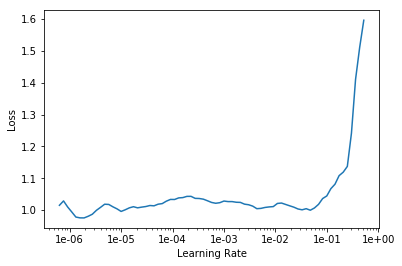

In [20]:
learn.recorder.plot(suggestion=True)

In [28]:
learn.fit_one_cycle(5,5e-2)

epoch,train_loss,valid_loss,accuracy,l_loss,ul_loss,time
0,1.168990,1.406796,0.544899,0.889152,0.050879,03:41
1,1.057315,0.756826,0.578143,0.860303,0.035820,03:41
2,0.923843,0.826465,0.546045,0.790366,0.024268,03:42
3,0.844720,0.870320,0.546045,0.732318,0.020437,03:42
4,0.815759,0.839737,0.546045,0.710393,0.019157,03:41


# CutMix

In [11]:
from fastai.torch_core import *
from fastai.callback import *
from fastai.callbacks.mixup import MixUpLoss
from fastai.basic_train import Learner, LearnerCallback

class CutMixCallback(LearnerCallback):
    "Callback that creates the cutmixed input and target."
    def __init__(self, learn:Learner, α:float=1., stack_y:bool=True, true_λ:bool=True):
        super().__init__(learn)
        self.α,self.stack_y,self.true_λ = α,stack_y,true_λ

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train: return
        λ = np.random.beta(self.α, self.α)
        λ = max(λ, 1- λ)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        #Get new input
        last_input_size = last_input.shape
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input.size(), λ)
        new_input = last_input.clone()
        new_input[:, ..., bby1:bby2, bbx1:bbx2] = last_input[shuffle, ..., bby1:bby2, bbx1:bbx2]
        λ = last_input.new([λ])
        if self.true_λ:
            λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
            λ = last_input.new([λ])
        if self.stack_y:
            new_target = torch.cat([last_target.unsqueeze(1).float(), y1.unsqueeze(1).float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)
        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix(learn:Learner, α:float=1., stack_x:bool=False, stack_y:bool=True, true_λ:bool=True) -> Learner:
    "Add mixup https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, α=α, stack_y=stack_y, true_λ=true_λ))
    return learn


In [38]:
learn = cutmix(cnn_learner(data, models.resnet34, metrics=[accuracy, f1_score]))

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


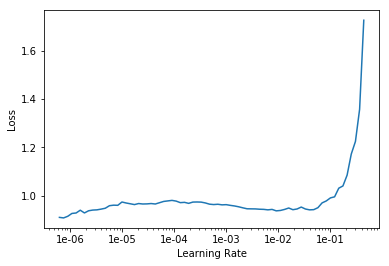

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(4,5e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.675114,0.697899,0.597249,0.364021,01:20
1,0.639170,0.612030,0.648452,0.495685,01:19
2,0.612215,0.564453,0.681697,0.575344,01:19
3,0.580247,0.562206,0.682079,0.592847,01:19


In [47]:
learn.save('cutmix-1')

In [48]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.588303,0.617415,0.671762,0.608280,01:22
1,0.597597,0.631631,0.647306,0.506243,01:23
2,0.582776,0.537973,0.704242,0.647566,01:24
3,0.557197,0.534449,0.721819,0.657715,01:25
4,0.546323,0.521862,0.727551,0.678210,01:25


## Sprinkles

In [26]:
def _cutout(x, max_holes=100, length=5):
    "Cut out `n_holes` number of square holes of size `length` in image at random locations."
    h,w = x.shape[1:]
    n_holes = np.random.randint(max_holes)
    for n in range(n_holes):
        h_y = np.random.randint(0, h)
        h_x = np.random.randint(0, w)
        y1 = int(np.clip(h_y - length / 2, 0, h))
        y2 = int(np.clip(h_y + length / 2, 0, h))
        x1 = int(np.clip(h_x - length / 2, 0, w))
        x2 = int(np.clip(h_x + length / 2, 0, w))
        x[:, y1:y2, x1:x2] = 0
    return x

my_cutout =  TfmPixel(_cutout, order=20)

In [49]:
def sprinkles_data(holes=50):
    tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.,xtra_tfms=my_cutout(max_holes=holes))
    data = (src.transform(tfms,size=224)
          .databunch(bs=40)
          .normalize(imagenet_stats)
         )
    return data

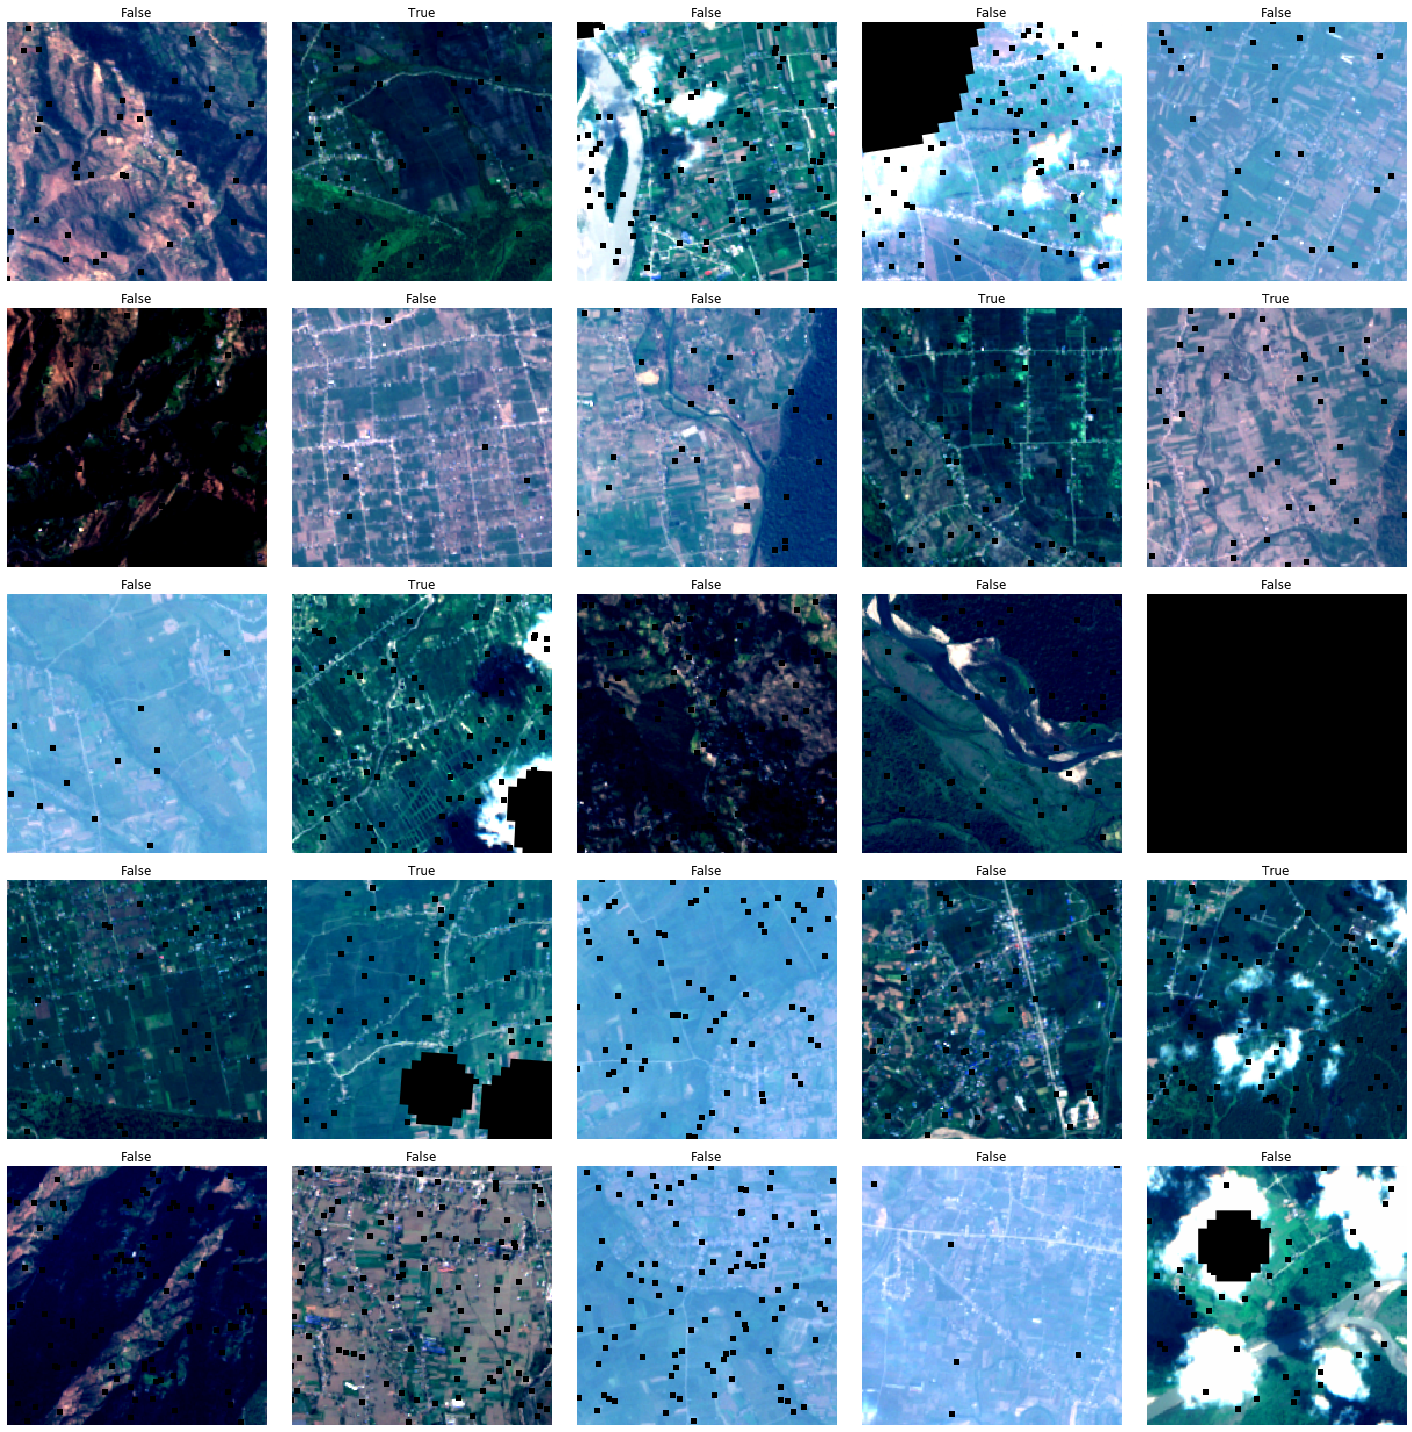

In [50]:
data = sprinkles_data(100)
data.show_batch()

In [29]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, f1_score])

In [14]:
learn.freeze()
learn.fit_one_cycle(4,5e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.646751,0.753224,0.575850,0.216531,01:33
1,0.615183,0.693811,0.606420,0.397170,01:27
2,0.555177,0.629229,0.676347,0.603219,01:26
3,0.528249,0.587570,0.692014,0.639719,01:27


In [16]:
learn.save('sprinkles-1')

In [15]:
learn.data = sprinkles_data(200)

In [17]:
learn.fit_one_cycle(4,1e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.530958,0.610509,0.679786,0.595821,01:33
1,0.533451,0.589497,0.698892,0.626657,01:34
2,0.519038,0.585953,0.696217,0.653193,01:34
3,0.522999,0.597297,0.699274,0.653185,01:33


In [18]:
learn.save('sprinkles-2')

In [20]:
learn.load('sprinkles-2');

In [21]:
learn.unfreeze()
learn.fit_one_cycle(4,slice(2e-5,2e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.533303,0.626464,0.701949,0.675721,01:36
1,0.518928,0.598387,0.697363,0.643081,01:35
2,0.489298,0.611847,0.699656,0.642502,01:37
3,0.447015,0.576375,0.714941,0.677753,01:35


In [22]:
learn.save('sprinkles-3')

In [23]:
learn.fit_one_cycle(6,slice(2e-5,2e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.452233,0.582935,0.717616,0.719890,01:36
1,0.480269,0.607404,0.709973,0.682086,01:36
2,0.438145,0.577809,0.738250,0.723343,01:37
3,0.433069,0.554449,0.732518,0.719950,01:37
4,0.410870,0.552864,0.742835,0.721216,01:37
5,0.384381,0.558810,0.741307,0.724886,01:36


In [24]:
learn.save('sprinkles-4')

In [27]:
learn.load('sprinkles-4');

In [28]:
learn.fit_one_cycle(10,slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.389621,0.564341,0.742835,0.732112,01:36
1,0.401819,0.580952,0.739014,0.728523,01:36
2,0.400186,0.595002,0.738250,0.699080,01:38
3,0.390147,0.627009,0.743600,0.726029,01:35
4,0.385308,0.649233,0.737486,0.700043,01:34
5,0.370230,0.554342,0.755063,0.743698,01:35
6,0.356446,0.583930,0.750478,0.731004,01:37
7,0.340977,0.571271,0.752006,0.741980,01:37
8,0.349794,0.602979,0.751624,0.735871,01:37
9,0.326407,0.590835,0.748185,0.733216,01:36


In [29]:
learn.save('sprinkles-5')

In [30]:
learn.load('sprinkles-5');

In [33]:
learn.data.train_ds.tfms[-1] = my_cutout(max_holes=250)

In [35]:
learn.fit_one_cycle(10,slice(5e-6,5e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.332500,0.554533,0.765380,0.745003,01:36
1,0.339332,0.551393,0.761559,0.737797,01:28
2,0.327237,0.559955,0.765762,0.742669,01:28
3,0.334768,0.576960,0.772640,0.745330,01:29
4,0.334441,0.576345,0.767291,0.745900,01:29
5,0.324163,0.568197,0.766909,0.747946,01:30
6,0.324963,0.573067,0.765762,0.742325,01:30
7,0.320625,0.564937,0.768055,0.747288,01:30
8,0.342129,0.575443,0.768819,0.737063,01:30
9,0.330784,0.567034,0.768437,0.741532,01:29


In [36]:
learn.save('sprinkles-6')

In [37]:
# learn.data.train_ds.tfms[-1] = my_cutout(max_holes=250)
learn.fit_one_cycle(10,slice(2e-6,2e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.319688,0.572693,0.763088,0.735130,01:27
1,0.335584,0.577152,0.771112,0.744229,01:29
2,0.328574,0.572149,0.768819,0.739789,01:29
3,0.325545,0.566056,0.770730,0.748644,01:27
4,0.326773,0.567079,0.767291,0.740519,01:28
5,0.327024,0.568291,0.767291,0.747657,01:28
6,0.313367,0.564390,0.772640,0.750740,01:27
7,0.324537,0.573336,0.764234,0.737538,01:28
8,0.324393,0.567618,0.770730,0.745829,01:27
9,0.321735,0.570873,0.770348,0.744863,01:29


In [ ]:
learn.save('sprinkles-7');

In [58]:
learn.load('sprinkles-7');

In [59]:
#Increased from 224->299
learn.data = sprinkles_data(250)

In [60]:
# learn.data.train_ds.tfms[-1] = my_cutout(max_holes=300)
learn.unfreeze()
learn.fit_one_cycle(10,slice(2e-6,2e-5))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.314082,0.560531,0.768819,0.747633,01:29
1,0.327050,0.575641,0.767673,0.730846,01:30
2,0.323447,0.567632,0.765762,0.730490,01:29
3,0.319372,0.574219,0.767673,0.737577,01:29
4,0.318310,0.572793,0.765762,0.741037,01:30
5,0.314980,0.570448,0.760031,0.732598,01:30
6,0.326179,0.569714,0.766527,0.733563,01:30
7,0.305624,0.569518,0.770730,0.740222,01:29
8,0.306399,0.569619,0.767673,0.736855,01:31
9,0.307068,0.562533,0.768437,0.741597,01:30


In [61]:
learn.save('sprinkles-8');

In [65]:
learn.load('sprinkles-8');

In [66]:
learn.data.train_ds.tfms[-1] = my_cutout(max_holes=300)
learn.fit_one_cycle(10,slice(1e-8,1e-6))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.304911,0.562454,0.767291,0.739367,01:34
1,0.301256,0.551912,0.763470,0.737250,01:32
2,0.299799,0.559049,0.768055,0.742645,01:32
3,0.301969,0.558308,0.765762,0.739329,01:31
4,0.306467,0.562818,0.769583,0.745501,01:32
5,0.311774,0.567425,0.764234,0.737138,01:32
6,0.311244,0.568265,0.768819,0.743209,01:31
7,0.310069,0.568776,0.769201,0.736666,01:33
8,0.303714,0.561903,0.768055,0.745636,01:32
9,0.296763,0.562138,0.771494,0.743099,01:33
